# Εισαγωγή

Στην παρούσα εργασία μελετάται η δημιουργία ενός νευρωνικού δικτύου για την ταξινόμηση σχολίων που αφορούν αεροπορικές εταιρείες.  
Τα **labels** που χρησιμοποιούνται είναι τρία: *αρνητικά*, *ουδέτερα* και *θετικά*.  
Για την αναπαράσταση των κειμένων χρησιμοποιήθηκαν δύο διαφορετικές τεχνικές:

- **TF-IDF Vectorizer**  
- **Προεκπαιδευμένα Word2Vec embeddings (Google News)**  

Η μελέτη ακολούθησε το παράδειγμα κώδικα που μας δόθηκε, με πειραματισμούς σε διαφορετικές παραμετροποιήσεις.  
Γενικά, οι αλλαγές στο μοντέλο δεν έφεραν μεγάλες διαφοροποιήσεις στην τελική απόδοση, με εξαίρεση την επιλογή της **weighted CrossEntropy loss**.  
Η χρήση weighting έδειξε να ισσοροπεί το **μη ισσοροπημένο dataset** (πολλά αρνητικά σχόλια). Τα αποτελέσματα έδειξαν ότι:  
- το **accuracy** μειώθηκε ελαφρώς,  
- η **απόδοση στα αρνητικά** σχόλια υποχώρησε,  
- ενώ οι κλάσεις *ουδέτερο* και *θετικό* παρουσίασαν σημαντική βελτίωση σε recall και F1.  

Αυτό ήταν αναμενόμενο: χωρίς weighting, το μοντέλο «ευνοούσε» τα αρνητικά λόγω ποσότητας, ενώ με weighting «ισορροπούσε» καλύτερα, μαθαίνοντας περισσότερα από τις μικρότερες κλάσεις.

Η πιο καθοριστική πτυχή της εργασίας δεν ήταν το ίδιο το νευρωνικό, αλλά η σωστή **επεξεργασία των κειμένων**.  
Ειδικότερα:  
- Η διατήρηση των **αρνήσεων** (που αρχικά αγνοούνταν από τον Lemmatizer) αύξησε αισθητά την απόδοση.  
- Η ανάλυση **n-grams (unigrams και bigrams)** βοήθησε στον εντοπισμό slang εκφράσεων και θορύβου, που διαφορετικά δεν θα εντοπίζονταν εύκολα.  

Από τις τεχνικές κανονικοποίησης στο νευρωνικό, η πιο αποτελεσματική ήταν το **Dropout**.  
Ακόμα και με υψηλές τιμές (0.7) διατηρήθηκαν καλά αποτελέσματα, ενώ οι τεχνικές **BatchNorm** και **LayerNorm** δεν έδειξαν σημαντική επίδραση.  
Η εφαρμογή **PCA** στα Word2Vec embeddings δοκιμάστηκε χωρίς βελτίωση.  

Όσον αφορά τον ρυθμό μάθησης, δοκιμάστηκαν διαφορετικοί **learning rate schedulers**, τόσο γραμμικά φθίνοντες όσο και δυναμικοί. Στα τελικά αποτελέσματα, ο γραμμικός scheduler αποδείχθηκε επαρκής, χωρίς σημαντικό πλεονέκτημα από πιο πολύπλοκους δυναμικούς schedulers.  

Τέλος, για το **batch size**, καλύτερα αποτελέσματα παρατηρήθηκαν στις τιμές **32–64**, ενώ σε μεγαλύτερες τιμές η απόδοση έπεφτε.  

---

Στη ροή της εργασίας που ακολουθεί:  
- Χρησιμοποιείται **χωρίς weighting** στο loss,  
- ο **γραμμικός LR scheduler** (μη δυναμικός),  
- και εφαρμόζεται **Dropout** ως βασική τεχνική regularization.  

In [4]:
# --- Βασικές βιβλιοθήκες ---
import numpy as np
import pandas as pd
import re
import copy
import html
import matplotlib.pyplot as plt

# --- PyTorch ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- Scikit-learn ---
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.decomposition import PCA

# --- NLP ---
import spacy
from gensim.models import KeyedVectors
# φορτώνουμε το αγγλικό μοντέλο μία φορά (κρατά tagger + lemmatizer)
nlp = spacy.load("en_core_web_sm")

# --- Για εξαγωγή σε pdf ---
from matplotlib.backends.backend_pdf import PdfPages  

# --- Ρυθμίσεις εμφάνισης pandas ---
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

### Συνάρτηση: `load_data`

**Σκοπός:**  
Φορτώνει δεδομένα από αρχείο (CSV/Excel) ή από ενσωματωμένο dataset του `sklearn`.

**Τι κάνει:**  
- Αν source = `'file'`: επιστρέφει `(df, None)` από `.csv` ή `.xls/.xlsx`  
- Αν source = `'sklearn'`: επιστρέφει `(df, target)` από dataset του `sklearn`  
- Σε Excel εμφανίζει διαθέσιμα sheets αν δεν δοθεί `sheet_name`  
- Εκτυπώνει πληροφορίες για το σχήμα του dataset

**Parameters:**  
- `source : str` → `'file'` (default) ή `'sklearn'`  
- `filepath : str or None` → διαδρομή αρχείου (για source='file')  
- `dataset_func : callable or None` → π.χ. `load_iris` (για source='sklearn')  
- `sheet_name : str or None` → όνομα φύλλου Excel  

**Returns:**  
- `df : pd.DataFrame` → τα δεδομένα  
- `target : np.ndarray or None` → ετικέτες στόχου (μόνο για sklearn datasets)  

In [5]:
def load_data(source='file', filepath=None,  dataset_func=None, sheet_name=None):
    """
    Φόρτωση δεδομένων από αρχείο (CSV/Excel) ή από ενσωματωμένο dataset του sklearn.

    Parameters
    source : str, optional
        'file' για τοπικό αρχείο (default) ή 'sklearn' για dataset του sklearn
    filepath : str or None
        Διαδρομή αρχείου όταν source='file'. Υποστηρίζει .csv, .xls, .xlsx
    dataset_func : callable or None
        Συνάρτηση από sklearn.datasets (π.χ. load_iris) όταν source='sklearn'
    sheet_name : str or None
        Όνομα φύλλου Excel (χρειάζεται μόνο για .xls/.xlsx)

    Returns
    tuple
        (df, target) όπου:
        df : pd.DataFrame με τα δεδομένα
        target : np.ndarray ή None με ετικέτες στόχου (για sklearn datasets)
    """
    if source == 'file':
        if not filepath:
            print("\nΠαρακαλώ δώσε filepath για CSV.")
            return None, None
        try:
            if filepath.endswith('.csv'):
                try:
                    df = pd.read_csv(filepath, encoding="utf-8")
                    print("\nDataset φορτώθηκε από CSV αρχείο:", df.shape)
                except UnicodeDecodeError:
                    df = pd.read_csv(filepath, encoding="utf-8-sig")
                    print("\nDataset φορτώθηκε από CSV αρχείο:", df.shape)
                return df, None
            elif filepath.endswith(('.xls', '.xlsx')):
                if sheet_name is None:
                    # εμφάνιση διαθέσιμων φύλλων (sheets) για επιλογή
                    xls = pd.ExcelFile(filepath)
                    print("\nΔιαθέσιμα φύλλα εργασίας (sheets):", xls.sheet_names)
                    print("Χρησιμοποίησε το όρισμα sheet_name για να διαλέξεις φύλλο.")
                    return None, None
                else:
                    df = pd.read_excel(filepath, sheet_name=sheet_name)
                    print("\n Dataset φορτώθηκε από XLS/XLSX αρχείο:", df.shape)
                    return df, None
        except Exception as e:
            print("\nΣφάλμα κατά το διάβασμα του αρχείου:", e)
            return None, None

    elif source == 'sklearn':
        if not dataset_func:
            print("\nΠαρακαλώ δώσε συνάρτηση π.χ. load_iris για φόρτωση sklearn dataset.")
            return None, None
        try:
            dataset = dataset_func()
            df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
            target = dataset.target
            print(f"\nDataset φορτώθηκε από sklearn ({dataset_func.__name__}):", df.shape)
            return df, target
        except Exception as e:
            print(f"\nΣφάλμα κατά το φόρτωμα του Dataset:", e)
            return None, None

    else:
        print("\nΜη έγκυρη επιλογή source. Δοκίμασε: 'file' ή 'sklearn'.")
        return None, None

### Συνάρτηση: `inspect_data`

**Σκοπός:**  
Γρήγορη επισκόπηση ενός `DataFrame`.

**Τι κάνει:**  
- Εμφανίζει σχήμα (γραμμές, στήλες)  
- Τύπους δεδομένων (`info()`)  
- Πρώτες γραμμές (`head()`)  
- Περιγραφικά στατιστικά (`describe()`)  
- Έλεγχο για NaN τιμές  
- Αν δοθεί `target_column`: εμφανίζει κατανομή τιμών (counts + ποσοστά)  

**Parameters:**  
- `df : pd.DataFrame` → το DataFrame προς ανάλυση  
- `target_column : str, optional` → στήλη με τις ετικέτες στόχου, αν υπάρχει  

**Returns:**  
- Δεν επιστρέφει κάτι, απλά τυπώνει πληροφορίες  

In [6]:
def inspect_data(df, target_column=None):
    """
    Γρήγορη επισκόπηση ενός DataFrame.

    Εμφανίζει:
    - Σχήμα (γραμμές, στήλες)
    - Τύπους δεδομένων και πλήθος NaN
    - Πρώτες γραμμές (head)
    - Περιγραφικά στατιστικά (describe)
    - Αν δοθεί target_column: κατανομή τιμών (counts και ποσοστά)

    Parameters
    df : pd.DataFrame
        Το DataFrame προς ανάλυση.
    target_column : str, optional
        Στήλη στόχου (π.χ. για ταξινόμηση). Αν υπάρχει, εμφανίζεται η κατανομή της.
    """
    print(f"\nΣχήμα DataFrame: {df.shape}")
    print("\nΠληροφορίες DataFrame:")
    df.info()
    print("\nΠρώτες 5 γραμμές:")
    print(df.head())
    print("\nΠεριγραφικά στατιστικά:")
    print(df.describe())
    print("\nΈλεγχος για NaN:")
    print(df.isna().sum())

    if target_column is not None and target_column in df.columns:
        print(f"\nΚατανομή Target labels ({target_column}):")
        print(df[target_column].value_counts())
        print("\nΚατανομή σε ποσοστά:")
        print(df[target_column].value_counts(normalize=True) * 100)

### Συνάρτηση: `clean_text`

**Σκοπός:**  
Καθαρίζει και κανονικοποιεί raw κείμενο για χρήση σε NLP/ML pipelines.

**Τι κάνει (ανάλογα με τα flags):**  
- Unescape HTML οντοτήτων και αφαίρεση HTML tags (χωρίς να σβήνει <3)  
- Αντικατάσταση αποστρόφου ’ → '  
- Αφαίρεση `&`  
- Αφαίρεση `@mentions`  
- Αφαίρεση `URLs` (http/https/www)  
- Αφαίρεση `#` από hashtags (κρατά τη λέξη)  
- Αφαίρεση ASCII emoticons και συμβόλων νομισμάτων  
- Αντικατάσταση αριθμών με `NUM` + συμπίεση πολλαπλών σε ένα  
- Αντικατάσταση `_` με κενό  
- Αφαίρεση artifacts (`{}`, `[]`, `<>`) και ειδικών συμβόλων (κρατώντας emojis/βασική στίξη)  
- Κανονικοποίηση έντασης:  
  - Συμπίεση ακολουθιών `!?`  
  - Μείωση πολλαπλών `!` ή `?` σε ένα  
  - Μείωση 3+ ίδιων γραμμάτων σε 2  
- Διορθώσεις artifacts:  
  - `flightled`, `flightle`, `flighted`, `flightr` → `flight`  
  - `rebooke` → `rebook`  
- Αντικατάσταση slang:  
  - `thx/thanks → thank`, `pls/plz → please`, `u → you`, `ur → your`, `ppl → people`  
- Μετατροπή σε πεζά (αν το flag είναι True)  
- Τελική συμπίεση πολλαπλών `num` σε ένα  
- Σύμπτυξη πολλαπλών κενών  

**Parameters:**  
- `text : str` → το αρχικό κείμενο  
- Όλα τα υπόλοιπα flags είναι `bool, optional` (default: True)  

**Returns:**  
- `str` → το καθαρισμένο/κανονικοποιημένο κείμενο  

In [7]:
def clean_text(text,
               clean_html=True,
               remove_amp=True,
               remove_mentions=True,
               remove_urls=True,
               strip_hashtags=True,
               remove_numbers=True,
               normalize_hyphens=True,
               remove_noise=True,
               normalize_intensity=True,
               to_lower=True,
               normalize_space=True):
    """
    Καθαρισμός/κανονικοποίηση κειμένου με επιμέρους επιλογές.

    Κάνει (ανάλογα με τα flags):
    - Unescape HTML οντοτήτων και αφαίρεση HTML tags, χωρίς να σβήνει μοτίβα τύπου <3
    - Αντικατάσταση ’ με ' (ενιαίο apostrophe)
    - Αφαίρεση & (replace με κενό)
    - Αφαίρεση @mentions
    - Αφαίρεση URLs (http(s)://... ή www.)
    - Αφαίρεση # από hashtags (κρατά τη λέξη), αφαίρεση ASCII emoticons όταν είναι αυτόνομα, αφαίρεση συμβόλων νομισμάτων
    - Αντικατάσταση αριθμών με 'NUM' και συμπίεση ακολουθιών NUM -> NUM
    - Αντικατάσταση '_' με κενό
    - Αφαίρεση artifacts τύπου {…}, […], <…> και ειδικών συμβόλων (κρατώντας emojis/βασική στίξη)
    - Κανονικοποίηση έντασης: συμπίεση ?!/!? ακολουθιών σε '!?', μείωση πολλαπλών ! και ? σε ένα, μείωση 3+ ίδιων γραμμάτων σε 2
    - Διορθώσεις για γνωστά artifacts ('flightled'/'flightle'/'flighted'/'flightr' -> 'flight', 'rebooke' -> 'rebook')
    - Αντικατάσταση slang (thx/thanks→thank, pls/plz→please, u→you, ur→your, ppl→people)
    - Προαιρετική μετατροπή σε πεζά
    - Τελική συμπίεση διαδοχικών 'num' → 'num' και σύμπτυξη πολλαπλών κενών

    Parameters
    text : str
        Το αρχικό κείμενο προς καθαρισμό
    clean_html, remove_amp, remove_mentions, remove_urls, strip_hashtags,
    remove_numbers, normalize_hyphens, remove_noise, normalize_intensity,
    to_lower, normalize_space : bool, optional
        Ενεργοποίηση/απενεργοποίηση των αντίστοιχων βημάτων (default: True)

    Returns
    str
        Το καθαρισμένο/κανονικοποιημένο κείμενο
    """
    s = text

    if clean_html:
        s = html.unescape(s)
        s = re.sub(r"</?[A-Za-z!][^>]*>", "", s)   # ασφαλές για να μη σβήνει <3

    # κανονικοποίηση κυρτού αποστρόφου: ’ -> '
    s = s.replace("’", "'")

    if remove_amp:
        s = s.replace("&", " ")

    if remove_mentions:
        s = re.sub(r"(?<!\w)@\w+", "", s)

    if remove_urls:
        s = re.sub(r"(https?://\S+|www\.\S+)", "", s)

    if strip_hashtags:
        s = re.sub(r"#(\w+)", r"\1", s)
        # ASCII emoticons (μόνο όταν δεν είναι μέσα σε λέξεις)
        s = re.sub(r'(?i)(?<!\w)(?:[:;=x][\-^]?[)D\(P/\\]|<3)(?!\w)', ' ', s)
        # σύμβολα νομισμάτων
        s = re.sub(r'[$€£¥₩₽₹¢฿]', ' ', s)

    if remove_numbers:
        s = re.sub(r"\d+", "NUM", s)
        s = re.sub(r"\bNUM(?:\W+NUM)+\b", "NUM", s)
        #s = re.sub(r"\d+", "", s)   # σβήνει όλους τους αριθμούς

    if normalize_hyphens:
        s = s.replace("_", " ")

    if remove_noise:
        s = re.sub(r"\{.*?\}|\[.*?\]|<.*?>", " ", s)
        s = re.sub(r"[©®™★☆•…–—·※“”\"]", " ", s)

    if normalize_intensity:
        s = re.sub(r'(?=[!?]*!)(?=[!?]*\?)[!?]{2,}', '!?', s)
        s = re.sub(r'!{2,}', '!', s)
        s = re.sub(r'\?{2,}', '?', s)
        s = re.sub(r'(.)\1{2,}', r'\1\1', s)

    # διόρθωση artifacts
    s = re.sub(r"\bflight(?:led|le|ed|r)\b", "flight", s, flags=re.IGNORECASE)
    s = re.sub(r"\brebooke\b", "rebook", s, flags=re.IGNORECASE)

    # αντικατάσταση slang
    slang_map = {
        "thx": "thank",
        "thanks": "thank",
        "pls": "please",
        "plz": "please",
        "u": "you",
        "ur": "your",
        "ppl": "people"
    }
    for k, v in slang_map.items():
        s = re.sub(rf"\b{k}\b", v, s, flags=re.IGNORECASE)

    if to_lower:
        s = s.lower()

    # συμπίεση διαδοχικών 'num' στο τέλος
    s = re.sub(r"\bnum(?:\W+num)+\b", "num", s)

    if normalize_space:
        s = re.sub(r"\s+", " ", s).strip()

    return s

### Συνάρτηση: `spacy_preprocess_batch`

**Σκοπός:**  
Προεπεξεργασία κειμένων με spaCy, γρήγορα με χρήση `nlp.pipe`.

**Τι κάνει:**  
- Κάνει tokenization & lemmatization  
- Αφαιρεί stopwords (εκτός από λέξεις άρνησης: `not`, `n't`, `no`, `never`)  
- Αφαιρεί σημεία στίξης, εκτός από `!` και `?`  
- Χρησιμοποιεί lemma αντί για raw token  
- Κανονικοποιεί διαδοχικά `num` σε ένα μόνο  

**Parameters:**  
- `texts : iterable of str` → λίστα ή iterable με κείμενα  
- `batch_size : int, optional` → μέγεθος batch για `nlp.pipe` (default=800)  

**Returns:**  
- `tokens_list : list[list[str]]` → λίστα με tokens για κάθε κείμενο  
- `lemmas_str_list : list[str]` → λίστα με ενιαία strings από τα tokens  

In [8]:
def spacy_preprocess_batch(texts, batch_size=800):
    """
    Προεπεξεργασία κειμένων με spaCy (batched για ταχύτητα).

    Βήματα:
    - Tokenization και lemmatization με nlp.pipe
    - Αφαίρεση stopwords (κρατάει όμως λέξεις άρνησης: not, n't, no, never)
    - Αφαίρεση σημείων στίξης, εκτός από ! και ?
    - Χρήση lemma αντί για raw token
    - Κανονικοποίηση αριθμών: διαδοχικά 'num' → ένα 'num'

    Parameters
    texts : iterable of str
        Λίστα ή iterable με κείμενα
    batch_size : int, optional
        Μέγεθος batch για nlp.pipe (default=800)

    Returns
    tokens_list : list of list of str
        Λίστα με tokens ανά κείμενο
    lemmas_str_list : list of str
        Λίστα με τα ίδια tokens σε μορφή ενιαίου string (join με κενά)
    """
    tokens_list = []
    lemmas_str_list = []
    NEGATION_WORDS = {"not", "n't", "no", "never"}

    for doc in nlp.pipe(texts, batch_size=batch_size):
        toks = []
        for token in doc:
            if token.is_stop and token.lower_ not in NEGATION_WORDS:
                continue
            if token.is_punct:
                if token.text in ("!", "?"):
                    toks.append(token.text)
                continue
            toks.append(token.lemma_)

        new_toks = []
        prev_is_num = False
        for t in toks:
            if t == "num" and prev_is_num:
                continue
            new_toks.append(t)
            prev_is_num = (t == "num")

        tokens_list.append(new_toks)
        lemmas_str_list.append(" ".join(new_toks))

    return tokens_list, lemmas_str_list

### Συνάρτηση: `top_ngrams`

**Σκοπός:**  
Υπολογίζει τα πιο συχνά **n-grams** (λέξεις ή φράσεις) σε μια συλλογή κειμένων.

**Τι κάνει:**   
- Υπολογίζει τις συχνότητες εμφάνισης όλων των n-grams  
- Φιλτράρει n-grams που εμφανίζονται τουλάχιστον `min_df` φορές  
- Επιστρέφει τα `top_k` πιο συχνά n-grams ταξινομημένα κατά φθίνουσα συχνότητα  

**Parameters:**  
- `texts : list[str]` → λίστα κειμένων  
- `ngram_range : tuple(int,int)` → π.χ. (1,1)=unigrams, (1,2)=unigrams+bigrams  
- `top_k : int` → πλήθος κορυφαίων n-grams (default=20)  
- `min_df : int` → ελάχιστη συχνότητα εμφάνισης (default=5)  

**Returns:**  
- `list[tuple(str,int)]` → λίστα με (n-gram, συχνότητα)  

In [9]:
def top_ngrams(texts, ngram_range=(1,1), top_k=20, min_df=5):
    """
    Υπολογισμός συχνότερων n-grams σε συλλογή κειμένων.

    Parameters
    ----------
    texts : list[str] ή iterable
        Λίστα κειμένων (strings) προς ανάλυση
    ngram_range : tuple(int,int), optional
        Εύρος n-grams, π.χ. (1,1)=unigrams, (1,2)=unigrams+bigrams (default=(1,1))
    top_k : int, optional
        Πλήθος πιο συχνών n-grams που θα επιστραφούν (default=20)
    min_df : int, optional
        Ελάχιστη συχνότητα εμφάνισης n-gram για να ληφθεί υπόψη (default=5)

    Returns
    -------
    list[tuple(str,int)]
        Λίστα από (ngram, συχνότητα) ταξινομημένη κατά φθίνουσα συχνότητα
    """
    vec = CountVectorizer(ngram_range=ngram_range, min_df=min_df, lowercase=False)
    X = vec.fit_transform(texts)
    freqs = np.asarray(X.sum(axis=0)).ravel()
    feats = vec.get_feature_names_out()
    idx = np.argsort(freqs)[::-1][:top_k]
    return list(zip(feats[idx], freqs[idx]))


### Συνάρτηση: `plot_bar`

**Σκοπός:**  
Οπτικοποιεί τα πιο συχνά n-grams ή λέξεις σε **bar chart**.

**Τι κάνει:**  
- Δέχεται λίστα από `(λέξη/n-gram, συχνότητα)`  
- Δημιουργεί οριζόντιο bar plot με τις συχνότητες  
- Αν η λίστα είναι άδεια, εμφανίζει μήνυμα  

**Parameters:**  
- `items : list[tuple(str,int)]` → λίστα με λέξεις/n-grams και τις συχνότητές τους  
- `title : str` → τίτλος διαγράμματος  

**Returns:**  
- Δεν επιστρέφει, απλά εμφανίζει γράφημα  

In [10]:
def plot_bar(items, title):
    """
    Οριζόντιο bar plot για συχνότητες n-grams ή λέξεων.

    Parameters
    ----------
    items : list[tuple(str,int)]
        Λίστα (λέξη/n-gram, συχνότητα)
    title : str
        Τίτλος διαγράμματος

    Returns
    -------
    None
    """
    if not items:
        print(f"{title}: (κανένα n-gram με τα τωρινά φίλτρα)")
        return
    words, counts = zip(*items)
    plt.figure(figsize=(10, 5))
    plt.barh(words[::-1], counts[::-1])
    plt.title(title)
    plt.tight_layout()
    plt.show()

### Συνάρτηση: `vectorize_texts`

**Σκοπός:**  
Μετατρέπει κείμενα σε διανύσματα με δύο μεθόδους: **TF-IDF** ή **Word2Vec**.

**Τι κάνει:**  
- Αν `method="tfidf"`:  
  - Χρησιμοποιεί `TfidfVectorizer` (μονογράμματα + διγράμματα, max_features=15000)  
  - Επιστρέφει `(X, vectorizer)` όπου `X` είναι `np.ndarray (float32)`  
- Αν `method="word2vec"`:  
  - Φορτώνει προεκπαιδευμένο μοντέλο Word2Vec (`.model` ή `.bin.gz`)  
  - Για κάθε κείμενο, παίρνει τον μέσο όρο των word embeddings των tokens που υπάρχουν στο μοντέλο  
  - Επιστρέφει `X : np.ndarray (float32)`  
- Αν δοθεί άγνωστη μέθοδος → `ValueError`

**Parameters:**  
- `df : pd.DataFrame` → πίνακας με τα κείμενα  
- `feature_name : str` → όνομα στήλης που περιέχει τα κείμενα/tokens  
- `method : str, optional` → `'tfidf'` (default) ή `'word2vec'`  
- `model_path : str or None` → path σε Word2Vec μοντέλο (χρειάζεται για word2vec)  
- `max_features : int, optional` → μέγιστος αριθμός χαρακτηριστικών για TF-IDF (default=15000)  

**Returns:**  
- `X : np.ndarray (float32)` → διανυσματική αναπαράσταση  
- `vectorizer : TfidfVectorizer` (μόνο για TF-IDF)  

In [11]:
def vectorize_texts(df, feature_name, method="tfidf", model_path=None, max_features=15000):
    """
    Μετατροπή κειμένων σε διανύσματα με TF-IDF ή Word2Vec.

    Parameters
    df : pd.DataFrame
        DataFrame που περιέχει τα κείμενα
    feature_name : str
        Όνομα της στήλης με το κείμενο ή τα tokens
    method : str, optional
        'tfidf' (default) ή 'word2vec'
    model_path : str or None
        Διαδρομή σε Word2Vec μοντέλο (.model ή .bin.gz) αν method='word2vec'
    max_features : int, optional
        Μέγιστος αριθμός χαρακτηριστικών για TF-IDF (default=15000)

    Returns
    TF-IDF:
        tuple (X, vectorizer)
        X : np.ndarray (float32), διανυσματική αναπαράσταση κειμένων
        vectorizer : fitted TfidfVectorizer
    Word2Vec:
        X : np.ndarray (float32), μέσος όρος των word embeddings ανά κείμενο
    """
    if method == "tfidf":
        print("Vectorizing with TF-IDF...")
        vectorizer = TfidfVectorizer(
            max_features=max_features,
            lowercase=False,   # ήδη lowercase
            stop_words=None,   # ήδη έκοψα stopwords
            ngram_range=(1, 2)
        )
        X = vectorizer.fit_transform(df[feature_name]).toarray().astype(np.float32, copy=False)
        return X, vectorizer

    elif method == "word2vec":
        if model_path is None:
            raise ValueError("Δώσε path στο Word2Vec μοντέλο (.model ή .bin.gz)")
        print(f"Loading Word2Vec model from: {model_path}")
        if model_path.endswith(".model"):
            model = KeyedVectors.load(model_path, mmap='r')
        else:
            model = KeyedVectors.load_word2vec_format(model_path, binary=True)

        print("Vectorizing with Word2Vec...")
        document_vectors = []
        for tokens in df[feature_name]:
            word_vecs = [model[w] for w in tokens if w in model]
            if word_vecs:
                document_vectors.append(np.mean(word_vecs, axis=0))
            else:
                document_vectors.append(np.zeros(model.vector_size))
        X = np.array(document_vectors, dtype=np.float32)
        return X

    else:
        raise ValueError("method πρέπει να είναι 'tfidf' ή 'word2vec'")

### Κλάση: `ANN`

**Σκοπός:**  
Απλό feedforward νευρωνικό δίκτυο με 1 ή 2 κρυφά επίπεδα.  
Υποστηρίζει επιλογή για **BatchNorm** ή **LayerNorm**.

**Τι κάνει:**  
- Δέχεται `input_dim` χαρακτηριστικά και δίνει `output_dim` εξόδους  
- Επιτρέπει επιλογή κανονικοποίησης (`norm="batch"`, `norm="layer"`, ή None)  
- Υποστηρίζει 1 ή 2 κρυφά επίπεδα  
- Σε κάθε κρυφό επίπεδο εφαρμόζει:  
  - `Linear → [Norm] → ReLU → Dropout`  

**Parameters:**  
- `input_dim : int` → μέγεθος εισόδου  
- `output_dim : int` → μέγεθος εξόδου (π.χ. αριθμός κατηγοριών)  
- `hidden_layer1 : int, optional` → νευρώνες στο πρώτο κρυφό επίπεδο (default=100)  
- `hidden_layer2 : int or None, optional` → αν δοθεί, προστίθεται δεύτερο κρυφό επίπεδο  
- `dropoutp1 : float, optional` → dropout rate για το πρώτο κρυφό επίπεδο (default=0.4)  
- `dropoutp2 : float, optional` → dropout rate για το δεύτερο κρυφό επίπεδο (default=0.4)  
- `norm : str or None, optional` → `'batch'`, `'layer'` ή `None` (default=None)  

**Forward Pass:**  
- Με 1 κρυφό επίπεδο:  
  `Input → Linear → [Norm] → ReLU → Dropout → Linear → Output`  
- Με 2 κρυφά επίπεδα:  
  `Input → Linear → [Norm] → ReLU → Dropout → Linear → [Norm] → ReLU → Dropout → Linear → Output`  

In [12]:
class ANN(nn.Module):
    """
    Απλό feedforward νευρωνικό δίκτυο με 1 ή 2 κρυφά επίπεδα.
    Υποστηρίζει επιλογή για BatchNorm ή LayerNorm.

    Parameters
    ----------
    input_dim : int
        Διαστάσεις εισόδου
    output_dim : int
        Διαστάσεις εξόδου (π.χ. αριθμός κατηγοριών)
    hidden_layer1 : int, optional
        Νευρώνες στο πρώτο κρυφό επίπεδο (default=100)
    hidden_layer2 : int or None, optional
        Νευρώνες στο δεύτερο κρυφό επίπεδο (default=None → μοντέλο με 1 κρυφό επίπεδο)
    dropoutp1 : float, optional
        Dropout probability για το πρώτο κρυφό επίπεδο (default=0.4)
    dropoutp2 : float, optional
        Dropout probability για το δεύτερο κρυφό επίπεδο (default=0.4)
    norm : str or None, optional
        'batch' για BatchNorm, 'layer' για LayerNorm, None για καθόλου normalization (default=None)

    Forward Pass
    ------------
    Με 1 κρυφό επίπεδο:
        input → Linear → [Norm] → ReLU → Dropout → Linear → output
    Με 2 κρυφά επίπεδα:
        input → Linear → [Norm] → ReLU → Dropout → Linear → [Norm] → ReLU → Dropout → Linear → output
    """

    def __init__(self, input_dim, output_dim, hidden_layer1=100, hidden_layer2=None,
                 dropoutp1=0.4, dropoutp2=0.4, norm=None):
        super(ANN, self).__init__()
        self.norm = norm

        # πρώτο κρυφό επίπεδο
        self.fc1 = nn.Linear(input_dim, hidden_layer1)
        if norm == "batch":
            self.norm1 = nn.BatchNorm1d(hidden_layer1)
        elif norm == "layer":
            self.norm1 = nn.LayerNorm(hidden_layer1)

        # αν υπάρχει δεύτερο κρυφό επίπεδο
        if hidden_layer2 is None:
            self.fc2 = nn.Linear(hidden_layer1, output_dim)
        else:
            self.fc2 = nn.Linear(hidden_layer1, hidden_layer2)
            if norm == "batch":
                self.norm2 = nn.BatchNorm1d(hidden_layer2)
            elif norm == "layer":
                self.norm2 = nn.LayerNorm(hidden_layer2)
            self.fc3 = nn.Linear(hidden_layer2, output_dim)

        # dropout layers
        self.dropout1 = nn.Dropout(p=dropoutp1)
        if hidden_layer2 is not None:
            self.dropout2 = nn.Dropout(p=dropoutp2)

    def forward(self, x):
        # πρώτο κρυφό
        x = self.fc1(x)
        if self.norm == "batch":
            x = self.norm1(x)
        elif self.norm == "layer":
            x = self.norm1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        # δεύτερο κρυφό (αν υπάρχει)
        if hasattr(self, "fc3"):
            x = self.fc2(x)
            if self.norm == "batch":
                x = self.norm2(x)
            elif self.norm == "layer":
                x = self.norm2(x)
            x = F.relu(x)
            x = self.dropout2(x)
            x = self.fc3(x)
        else:
            x = self.fc2(x)

        return x

### Συνάρτηση: `train_model`

**Σκοπός:**  
Εκπαιδεύει PyTorch μοντέλο (CPU-only), καταγράφει train/val loss & accuracy,  
χρησιμοποιεί **Early Stopping** (με αποθήκευση και restore των καλύτερων βαρών)  
και υποστηρίζει **LR scheduler** ανά εποχή.

**Τι κάνει:**  
- Loop σε epochs με train/validation φάσεις  
- Υπολογισμός loss/accuracy ανά εποχή  
- Early stopping με `patience` και `min_delta`  
- Αν υπάρχει scheduler:  
  - `ReduceLROnPlateau` → `scheduler.step(val_loss)`  
  - αλλιώς → `scheduler.step()`  

**Parameters:**  
- `model` (nn.Module), `train_loader`, `val_loader`  
- `criterion` (loss), `optimizer`  
- `num_epochs`, `patience`, `scheduler` (optional)  

**Returns:**  
- `model` (με restore στα καλύτερα weights)  
- `train_losses`, `val_losses`, `train_accuracies`, `val_accuracies`  

In [13]:
def train_model(
        model,
        train_loader,
        val_loader,
        criterion,          # π.χ. nn.CrossEntropyLoss()
        optimizer,          # π.χ. torch.optim.Adam(model.parameters()
        num_epochs=20,
        patience=5,
        scheduler=None
):
    """
    Trains a PyTorch model (CPU only) with early stopping based on validation loss.

    Args:
        model (torch.nn.Module): The neural network model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
        criterion (torch.nn.Module): Loss function (e.g., CrossEntropyLoss).
        optimizer (torch.optim.Optimizer): Optimizer for model parameters (e.g., Adam, SGD).
        num_epochs (int): Maximum number of epochs to train. Defaults to 20.
        patience (int): Early stopping patience. Defaults to 5.

    Returns:
        model, train_losses, val_losses, train_accuracies, val_accuracies
    """
    # EarlyStopping
    early_stopping = EarlyStopping(patience=patience, min_delta=0.0001)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # CPU only
    model.cpu()

    for epoch in range(num_epochs):
        # -----------------------
        # 1) Training phase
        # -----------------------
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs = inputs.float()  # [batch, features]
            # CrossEntropyLoss: labels σε LongTensor (class indices)
            if isinstance(criterion, nn.CrossEntropyLoss):
                labels = labels.long()

            optimizer.zero_grad()
            outputs = model(inputs)       # logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # Accuracy
            _, predicted = torch.max(outputs, dim=1)
            correct_preds += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_preds / total_samples if total_samples > 0 else 0.0
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # -----------------------
        # 2) Validation phase
        # -----------------------
        model.eval()
        running_val_loss = 0.0
        correct_val_preds = 0
        val_samples = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.float()
                if isinstance(criterion, nn.CrossEntropyLoss):
                    labels = labels.long()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, dim=1)
                correct_val_preds += (predicted == labels).sum().item()
                val_samples += labels.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        
        # --- επιλογή scheduler step ---
       
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(epoch_val_loss)   # αυτός ο scheduler ΘΕΛΕΙ metric (π.χ. val loss)
        else:
            scheduler.step()   
        
        epoch_val_acc = correct_val_preds / val_samples if val_samples > 0 else 0.0
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | "
              f"Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")

        # -----------------------
        # 3) Early stopping
        # -----------------------
        # Χρει΄ζαται και το model/epoch για να κρατάει τα καλύτερα βάρη
        early_stopping(epoch_val_loss, model=model, epoch=epoch)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    # Επαναφορά καλύτερων βαρών (αν έχουν αποθηκευτεί)
    if early_stopping.best_state_dict is not None:
        early_stopping.restore_best_weights(model)
        print(f"Restored best weights from epoch {early_stopping.best_epoch + 1} "
              f"(best val loss: {early_stopping.best_loss:.4f}).")

    return model, train_losses, val_losses, train_accuracies, val_accuracies

### Κλάση: `EarlyStopping`

**Σκοπός:**  
Διακόπτει την εκπαίδευση όταν το validation loss δεν βελτιώνεται για `patience` εποχές και κρατά snapshot των καλύτερων weights.

**Τι κάνει:**  
- Στην πρώτη κλήση ή όταν υπάρξει βελτίωση (πάνω από `min_delta`) αποθηκεύει deepcopy των weights  
- Αυξάνει `counter` όταν δεν υπάρχει βελτίωση  
- Όταν `counter >= patience` → `early_stop = True`  
- Με `restore_best_weights(model)` επαναφέρει τα καλύτερα weights  

**Parameters:**  
- `patience : int` → πόσες εποχές χωρίς βελτίωση πριν σταματήσει (default=5)  
- `min_delta : float` → ελάχιστη απαιτούμενη βελτίωση στο `val_loss` (default=0.0)  

**Χρήση (παράδειγμα):**  
```python
es = EarlyStopping(patience=5, min_delta=1e-4)
for epoch in range(epochs):
    # train...
    # validate...
    es(val_loss, model=model, epoch=epoch)
    if es.early_stop:
        break
es.restore_best_weights(model)

In [14]:
class EarlyStopping:
    """
    Early stopping με παρακολούθηση validation loss και αποθήκευση καλύτερων weights.

    Λογική:
    - Στην πρώτη κλήση ή σε κάθε βελτίωση του val_loss (> min_delta), γίνεται snapshot των weights
    - Αν δεν υπάρχει βελτίωση για 'patience' συνεχόμενες εποχές, ενεργοποιείται early_stop=True
    - Παρέχεται restore_best_weights(model) για επαναφορά των καλύτερων weights

    Parameters
    patience : int, optional
        Πλήθος διαδοχικών εποχών χωρίς βελτίωση πριν γίνει early stop (default=5)
    min_delta : float, optional
        Ελάχιστη απαιτούμενη βελτίωση στο val_loss για να θεωρηθεί βελτίωση (default=0.0)

    Attributes
    counter : int
        Μετρητής εποχών χωρίς βελτίωση
    best_loss : float or None
        Καλύτερη τιμή val_loss που έχει παρατηρηθεί
    early_stop : bool
        Σημαία που υποδεικνύει αν πρέπει να σταματήσει η εκπαίδευση
    best_state_dict : dict or None
        Αντίγραφο των καλύτερων weights του μοντέλου (deepcopy)
    best_epoch : int
        Δείκτης εποχής (0-based) όπου επιτεύχθηκε το καλύτερο val_loss
    """

    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_state_dict = None
        self.best_epoch = -1

    def __call__(self, val_loss, model=None, epoch=None):
        # snapshot στην 1η κλήση ΚΑΙ σε κάθε βελτίωση
        if self.best_loss is None or val_loss < (self.best_loss - self.min_delta):
            self.best_loss = val_loss
            self.counter = 0
            if model is not None:
                self.best_state_dict = copy.deepcopy(model.state_dict())  # <-- deepcopy
            if epoch is not None:
                self.best_epoch = epoch
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def restore_best_weights(self, model):
        if self.best_state_dict is None:
            print("No snapshot saved — check EarlyStopping call got model/epoch.")
            return
        model.load_state_dict(self.best_state_dict)
        #print(f"Restored best weights from epoch {self.best_epoch + 1} "
        #      f"(best val loss: {self.best_loss:.4f}).")

##### `Η παρακάτω συναρτηση ειναι αυτούσια από το παράδειγμα`
### Συνάρτηση: `plot_losses_to_pdf`

**Σκοπός:**  
Σχεδιάζει τις καμπύλες **training** και **validation loss** και αποθηκεύει το γράφημα σε PDF.

**Τι κάνει:**  
- Δημιουργεί γραφική παράσταση με `matplotlib`  
- Σχεδιάζει τις καμπύλες train/val loss ανά epoch  
- Αποθηκεύει το γράφημα σε PDF (`PdfPages`)  
- Προαιρετικά εμφανίζει το γράφημα στην οθόνη (`show_plot=True`)  

**Parameters:**  
- `train_losses : list` → training loss ανά εποχή  
- `val_losses : list` → validation loss ανά εποχή  
- `pdf_filename : str` → όνομα αρχείου PDF (default: 'training_validation_losses.pdf')  
- `figsize : tuple` → μέγεθος σχήματος (default: (8, 6))  
- `show_plot : bool` → αν εμφανίζεται το γράφημα στην οθόνη (default=False)  

**Returns:**  
- `str` → το όνομα του PDF αρχείου που δημιουργήθηκε  

In [15]:
def plot_losses_to_pdf(
        train_losses,
        val_losses,
        pdf_filename='training_validation_losses.pdf',
        figsize=(8, 6),
        show_plot=False,
):
    """
    Plots the training and validation losses,
    and saves the figure to a PDF file.

    Args:
        train_losses (list): Training loss per epoch.
        val_losses (list): Validation loss per epoch.
        pdf_filename (str): Name/path of the PDF file to save.
        figsize (tuple): Size of the figure (width, height in inches).
        show_plot (bool): Show the plot or not.
    Return:
        pdf_filaname (str): The filename of the generated pdf.
    """
    # Create a figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)

    # Plot the train/val curves
    ax.plot(train_losses, label="Train Loss")
    ax.plot(val_losses, label="Val Loss")

    ax.set_title("Training & Validation Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()

    # Save the current figure into a PDF
    with PdfPages(pdf_filename) as pdf:
        pdf.savefig(fig)  # Save the figure in the PDF

    # Optionally display in interactive environments
    if show_plot:
        plt.show()
    # Close the figure to free memory
    plt.close(fig)
    print(f"The learning curves are generated in pdf: {pdf_filename}")
    return pdf_filename

## Συνάρτηση: `get_preds`

**Σκοπός:**  
Επιστρέφει τις πραγματικές ετικέτες (`y_true`) και τις αντίστοιχες προβλέψεις του μοντέλου (`y_pred`) από ένα DataLoader.

**Τι κάνει:**  
- Θέτει το μοντέλο σε `eval()` mode (απενεργοποιεί dropout/batchnorm).  
- Χρησιμοποιεί `torch.no_grad()` για ταχύτερο inference χωρίς gradients.  
- Για κάθε batch:  
  - Υπολογίζει τις προβλέψεις (`argmax` στα logits).  
  - Αποθηκεύει τόσο τις πραγματικές ετικέτες όσο και τις προβλέψεις.  
- Ενώνει όλα τα batches σε δύο NumPy arrays.

**Returns:**  
- `y_true` → ground truth labels  
- `y_pred` → predicted labels  

In [16]:
def get_preds(model, loader):
    """
    Εξάγει τις πραγματικές ετικέτες και τις προβλέψεις του μοντέλου από DataLoader.

    Parameters
    ----------
    model : torch.nn.Module
        Το εκπαιδευμένο PyTorch μοντέλο.
    loader : torch.utils.data.DataLoader
        DataLoader για το dataset (val/test).

    Returns
    -------
    y_true : np.ndarray
        Πραγματικές ετικέτες (ground truth).
    y_pred : np.ndarray
        Προβλέψεις του μοντέλου (class indices).
    """
    model.eval()
    ys, yhat = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.float()
            preds = model(xb).argmax(dim=1)
            ys.append(yb.cpu().numpy())
            yhat.append(preds.cpu().numpy())
    return np.concatenate(ys), np.concatenate(yhat)

## Φόρτωση Δεδομένων

Ξεκινάμε φορτώνοντας το dataset **Tweets.csv** με τη συνάρτηση `load_data`.  
Η συνάρτηση υποστηρίζει ανάγνωση είτε από αρχεία (CSV/Excel), είτε από datasets του sklearn.  
Εδώ φορτώνουμε το αρχείο τοπικά από τον φάκελο `datasets/`.

Η `load_data` στην περίπτωση CSV:
- Ελέγχει πρώτα αν μπορεί να διαβαστεί με **UTF-8**  
- Αν αποτύχει (π.χ. σφάλμα `UnicodeDecodeError`), ξαναδοκιμάζει με **UTF-8-SIG**  

```python
df, _ = load_data(source='file', filepath='datasets/Tweets.csv', dataset_func=None, sheet_name=None)

In [17]:
df,_ = load_data(source='file', filepath='datasets/Tweets.csv',  dataset_func=None, sheet_name=None)


Dataset φορτώθηκε από CSV αρχείο: (14640, 15)


## Επισκόπηση Δεδομένων

Χρησιμοποιούμε τη συνάρτηση `inspect_data` για μια πρώτη επισκόπηση του dataset.  
Η συνάρτηση εμφανίζει:
- Σχήμα του DataFrame (γραμμές, στήλες)  
- Τύπους δεδομένων και NaN counts  
- Πρώτες γραμμές (head)  
- Περιγραφικά στατιστικά (describe)  

```python
inspect_data(df, target_column=None)

Ευρήματα:

    Το dataset έχει 14640 γραμμές και 15 στήλες

    Η στήλη text (που περιέχει τα tweets) και η στήλη airline_sentiment (στόχος) δεν έχουν NaN → καλό για ανάλυση

    Η στήλη airline_sentiment είναι τύπου object (κατηγορικές τιμές → χρειάζεται κωδικοποίηση)

    Υπάρχουν αρκετές στήλες με ελλιπή δεδομένα (π.χ. negativereason, tweet_coord, tweet_location, user_timezone)

    Στα παραδείγματα της στήλης text βλέπουμε ότι τα δεδομένα είναι tweets με πολλά "σκουπίδια" (mentions @user, URLs, σύμβολα, HTML entities &amp; κλπ.), κάτι που θα χρειαστεί καθαρισμό/προεπεξεργασία στο επόμενο βήμα

In [18]:
inspect_data(df, target_column=None)


Σχήμα DataFrame: (14640, 15)

Πληροφορίες DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_

## Επιλογή Χρήσιμων Στηλών

Από το αρχικό dataset κρατάμε μόνο τις στήλες που μας ενδιαφέρουν:  

- **`text`** → περιέχει το tweet (features)  
- **`airline_sentiment`** → περιέχει το sentiment (target)  

Παράλληλα, με `dropna()` αφαιρούμε τυχόν γραμμές που έχουν κενές τιμές σε αυτές τις δύο στήλες.  

```python
df = df[["text", "airline_sentiment"]].dropna()

In [19]:
df = df[["text", "airline_sentiment"]].dropna()

## Κωδικοποίηση Ετικετών (Label Encoding)

Για να χρησιμοποιήσουμε τις ετικέτες `airline_sentiment` στο μοντέλο, πρέπει να τις μετατρέψουμε από κατηγορικές τιμές (strings) σε ακέραιους αριθμούς.  
Αυτό γίνεται με τον **`LabelEncoder`** της `sklearn`.

Πλέον η στήλη label περιέχει την αριθμητική αναπαράσταση των sentiments:

0 → negative

1 → neutral

2 → positive

In [21]:
le = LabelEncoder()
df["label"] = le.fit_transform(df["airline_sentiment"])

print("Classes (με τη σειρά των ids):", list(le.classes_))
print("Αριθμός κλάσεων:", len(le.classes_))

# Κατανομή labels (absolute counts)
print("\nΚατανομή κλάσεων (counts):")
print(df["airline_sentiment"].value_counts())

# Κατανομή labels (ποσοστά %)
print("\nΚατανομή κλάσεων (ποσοστά):")
print(df["airline_sentiment"].value_counts(normalize=True) * 100)

Classes (με τη σειρά των ids): ['negative', 'neutral', 'positive']
Αριθμός κλάσεων: 3

Κατανομή κλάσεων (counts):
airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

Κατανομή κλάσεων (ποσοστά):
airline_sentiment
negative    62.691257
neutral     21.168033
positive    16.140710
Name: proportion, dtype: float64


## Κατανομή Κλάσεων

Η κατανομή των labels δείχνει ότι το dataset είναι **ανισόρροπο (imbalanced)**:  
- **Negative:** ~62.7%  
- **Neutral:** ~21.2%  
- **Positive:** ~16.1%  

Η πλειοψηφία των παραδειγμάτων είναι αρνητικά, γεγονός που επηρεάζει την εκπαίδευση και μπορεί να οδηγήσει το μοντέλο να «προτιμά» την αρνητική κλάση.

In [18]:
display(df["text"].head(-5))

0                                                                                                                  @VirginAmerica What @dhepburn said.
1                                                                             @VirginAmerica plus you've added commercials to the experience... tacky.
2                                                                              @VirginAmerica I didn't today... Must mean I need to take another trip!
3                       @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
4                                                                                              @VirginAmerica and it's a really big bad thing about it
                                                                             ...                                                                      
14630                                                                                         

## Καθαρισμός Κειμένων

Στα tweets υπάρχουν πολλά "σκουπίδια" (mentions, URLs, hashtags, σύμβολα, κλπ.), οπότε εφαρμόζουμε καθαρισμό με τη συνάρτηση `clean_text`.  

Βήματα καθαρισμού:  
- Αφαίρεση **hashtags** (κρατάει μόνο τη λέξη)  
- Αφαίρεση **URLs**  
- Αφαίρεση **mentions** (@user)  
- Αφαίρεση **ASCII emoticons** και **ειδικών συμβόλων**  
- Μετατροπή αριθμών σε `NUM`, και διαδοχικά `NUM NUM` → `NUM` (τα πολλαπλά `NUM` δεν προσφέρουν έξτρα πληροφορία)  
- Κανονικοποίηση αποστρόφου (’ → ') για να λειτουργεί σωστά ο **lemmatizer**  
- Κανονικοποίηση γραμμάτων με πολλές επαναλήψεις (π.χ. *soooo* → *soo*) ώστε να διατηρείται το συναισθηματικό φορτίο αλλά χωρίς υπερβολές  
- Κανονικοποίηση `!?` σε μία φορά → π.χ. `!!!` → `!`, `???` → `?`, `?!??!` → `!?` (κρατάμε το σήμα του συναισθήματος αλλά το ελέγχουμε)  
- **Slang replacement** (π.χ. `thx → thank`, `pls/plz → please`, `u → you`, `ur → your`, `ppl → people`)  
- **Διορθώσεις artifacts** (π.χ. `flightled`, `flightle`, `flighted`, `flightr` → `flight`, `rebooke` → `rebook`)  
- Μετατροπή σε **πεζά**  
- **Normalize space** (πολλαπλά κενά → 1)  
- Διατήρηση **emojis** (δεν αφαιρούνται, γιατί συχνά κουβαλάνε σημαντική συναισθηματική πληροφορία)  

```python
df.loc[:, "cleaned_text"] = df["text"].apply(clean_text)
```
Με αυτό τον τρόπο δημιουργούμε μια νέα στήλη cleaned_text με κείμενα καθαρισμένα αλλά με διατήρηση βασικών στοιχείων συναισθήματος (π.χ. ένταση, emojis, placeholder NUM).

In [19]:
df.loc[:, "cleaned_text"] = df["text"].apply(clean_text)

In [20]:
display(df["cleaned_text"].head(-5))

0                                                                                                                           what said.
1                                                                             plus you've added commercials to the experience.. tacky.
2                                                                              i didn't today.. must mean i need to take another trip!
3                              it's really aggressive to blast obnoxious entertainment in your guests' faces they have little recourse
4                                                                                             and it's a really big bad thing about it
                                                                     ...                                                              
14630                                                                                                                    thank! he is.
14631                       thank for nothing on gettin

## Tokenization & Lemmatization (spaCy)

Χρησιμοποιούμε την `spacy_preprocess_batch` για να πάρουμε:
- `tokens` (λίστα tokens ανά tweet) — χρήσιμο για **Word2Vec**
- `lemmas_str` (ενιαίο string με lemmas) — χρήσιμο για **TF-IDF**

```python
tokens_col, lemmas_col = spacy_preprocess_batch(df["cleaned_text"].tolist(), batch_size=800)
df["tokens"] = tokens_col
df["lemmas_str"] = lemmas_col
```

Σχεδιαστικές επιλογές (και γιατί):

Κρατάμε λέξεις άρνησης (not, n't, no, never)
→ Η άρνηση αλλάζει το sentiment, άρα είναι σημαντική πληροφορία.

Φιλτράρουμε στίξη, αλλά κρατάμε ! και ?
→ Η ένταση/αμφιβολία συμβάλλει στο sentiment (π.χ. εκνευρισμός, ειρωνεία).

Lemmatization
→ Φέρνουμε τις λέξεις στη βασική τους μορφή (π.χ. delays, delayed → delay) για να μειώσουμε το λεξιλόγιο χωρίς να χάσουμε νόημα.

Επανέλεγχος για διαδοχικά num
→ Μετά τον καθαρισμό/πεζοποίηση μπορεί να προκύψουν νέα num; τα συμπτύσσουμε ξανά ώστε num num → num.

Batch processing (nlp.pipe)
→ Το batch_size=800 επιταχύνει σημαντικά (ένας lemmatizer pass για όλα), ενώ επιστρέφουμε ταυτόχρονα tokens και ενιαίο string ώστε να μη χρειαστούν διπλά περάσματα.

Τι παίρνουμε στο τέλος:

`df["tokens"]` → λίστα lemmas ανά tweet (κατάλληλο για **Word2Vec** averaging)

`df["lemmas_str"]` → ενιαίο κείμενο lemmas (κατάλληλο για **TF-IDF**)

In [21]:
tokens_col, lemmas_col = spacy_preprocess_batch(df["cleaned_text"].tolist(), batch_size=800)
df["tokens"] = tokens_col
df["lemmas_str"] = lemmas_col

In [22]:
display(df[["tokens"]].head(-5))

,tokens
0,[say]
1,"[plus, add, commercial, experience, tacky]"
2,"[not, today, mean, need, trip, !]"
3,"[aggressive, blast, obnoxious, entertainment, guest, face, little, recourse]"
4,"[big, bad, thing]"
...,...
14630,"[thank, !]"
14631,"[thank, get, country, break, plane, ?, come]"
14632,"[george, not, look, good, follow, link, start, refund, process]"
14633,"[flight, cancel, flight, leave, tomorrow, morning, auto, rebooke, tuesday, night, flight, need, arrive, monday]"


## Εξερεύνηση n-grams (Overall)

Υπολογίζουμε τα **Top-20 unigrams** και **Top-20 bigrams** πάνω στα lemmas (`lemmas_str`) για όλο το corpus, με `min_df=5` ώστε να φιλτράρουμε πολύ σπάνιες φράσεις.

```python
# --- Overall ---
uni_overall = top_ngrams(df["lemmas_str"], (1,1), top_k=20, min_df=5)
bi_overall  = top_ngrams(df["lemmas_str"], (2,2), top_k=20, min_df=5)

plot_bar(uni_overall, "Top-20 Unigrams (lemmas, overall, min_df=5)")
plot_bar(bi_overall,  "Top-20 Bigrams (lemmas, overall, min_df=5)")
```
**Παρατηρήσεις**

Το `placeholder num` εμφανίζεται συχνά (π.χ. `num hour`, `num minute`, `flight num`) — επιβεβαιώνει ότι τα χρονικά/αριθμητικά μοτίβα είναι πολύ συνηθισμένα στα `παράπονα` (χρόνοι αναμονής, αριθμοί πτήσεων).

Οι `αρνήσεις` διασώζονται σωστά: not, no, will not, flight not → καλό σημάδι για `sentiment`.

Εμφανείς θεματικές: `καθυστερήσεις/ακυρώσεις` (delay, cancel flight, late flight), `εξυπηρέτηση` (customer service), `χρόνος/αναμονή` (hour, wait, hold), `αποσκευές` (bag), `πύλες` (gate agent).

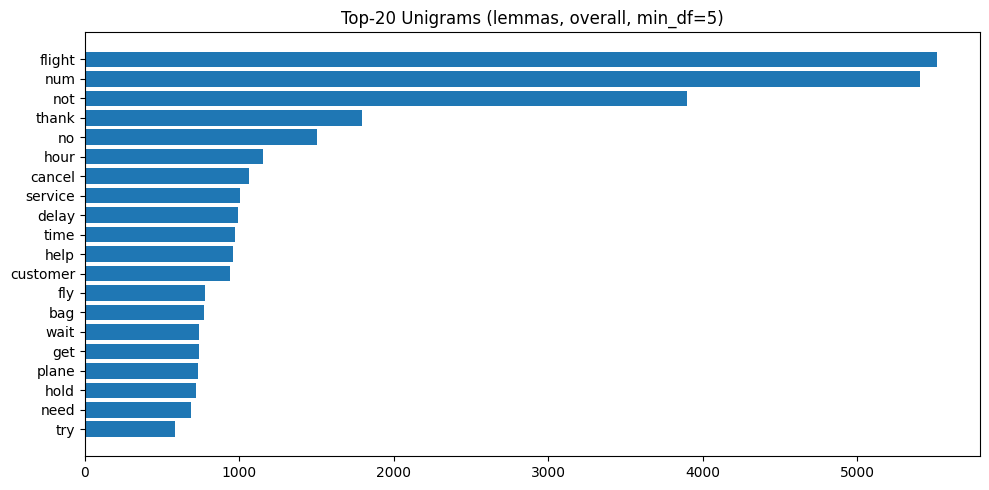

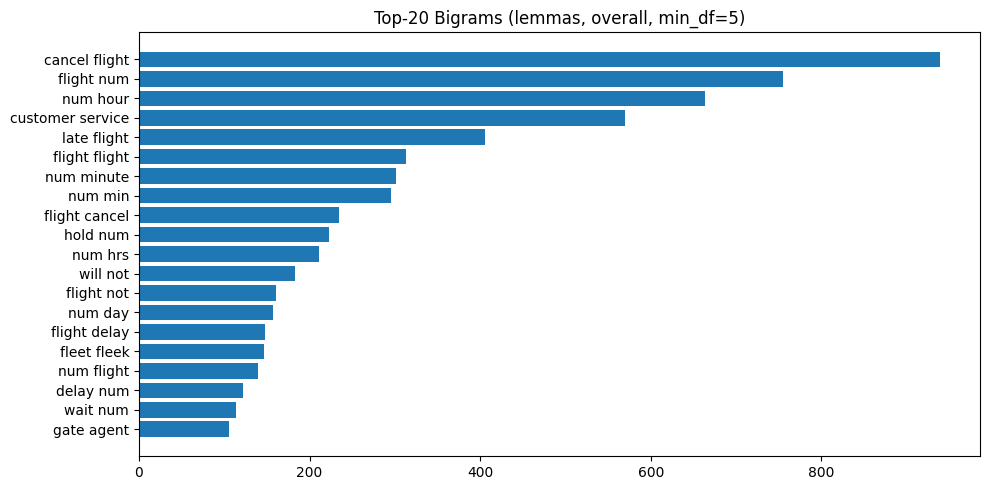

In [23]:
uni_overall = top_ngrams(df["lemmas_str"], (1,1), top_k=20, min_df=5)
bi_overall  = top_ngrams(df["lemmas_str"], (2,2), top_k=20, min_df=5)

plot_bar(uni_overall, "Top-20 Unigrams (lemmas, overall, min_df=5)")
plot_bar(bi_overall,  "Top-20 Bigrams (lemmas, overall, min_df=5)")

## Έλεγχος & Αφαίρεση Κενών/NaN μετά το spaCy

Μετά το `clean_text` και το `spacy_preprocess_batch`, ελέγχουμε αν υπάρχουν κενές ή `NaN` τιμές στις παραγόμενες στήλες:
- **`tokens`** (λίστα με lemmas για Word2Vec)
- **`lemmas_str`** (ενιαίο string για TF-IDF)

Ελέγχουμε ξεχωριστά:
- `mask_tokens_nan` / `mask_lemmas_nan` → αν υπάρχουν NaN
- `mask_tokens_empty` → λίστες χωρίς tokens (`len(x) == 0`)
- `mask_lemmas_empty` → strings που είναι κενά ή μόνο κενά διαστήματα

Στη συνέχεια:
- Φτιάχνουμε ενοποιητική μάσκα `bad_mask`
- **Αφαιρούμε** όλες τις προβληματικές γραμμές και κάνουμε `reset_index`

**Γιατί το κάνουμε;**
- Οι vectorizers (π.χ. TF-IDF) και τα embeddings **δεν** θέλουν κενές εγγραφές.
- Κενά tokens/strings εμφανίζονται όταν το κείμενο μετά τον καθαρισμό δεν έχει «ουσιαστικό» περιεχόμενο.
- Η αφαίρεση αυτών των γραμμών αποφεύγει σφάλματα.


In [24]:
mask_tokens_nan   = df["tokens"].isna()
mask_tokens_empty = df["tokens"].map(lambda x: len(x) == 0)

mask_lemmas_nan   = df["lemmas_str"].isna()
mask_lemmas_empty = df["lemmas_str"].astype(str).str.strip().eq("")

print("NaN tokens:",   mask_tokens_nan.sum())
print("Empty tokens:", mask_tokens_empty.sum())
print("NaN lemmas_str:",   mask_lemmas_nan.sum())
print("Empty lemmas_str:", mask_lemmas_empty.sum())

NaN tokens: 0
Empty tokens: 34
NaN lemmas_str: 0
Empty lemmas_str: 34


In [25]:
bad_mask = mask_tokens_nan | mask_tokens_empty | mask_lemmas_nan | mask_lemmas_empty
print("\nΣύνολο που θα αφαιρεθούν:", bad_mask.sum())

df = df.loc[~bad_mask].reset_index(drop=True)
print("Νέο μέγεθος df:", len(df))


Σύνολο που θα αφαιρεθούν: 34
Νέο μέγεθος df: 14606


In [26]:
mask_tokens_nan   = df["tokens"].isna()
mask_tokens_empty = df["tokens"].map(lambda x: len(x) == 0)

mask_lemmas_nan   = df["lemmas_str"].isna()
mask_lemmas_empty = df["lemmas_str"].astype(str).str.strip().eq("")

print("NaN tokens:",   mask_tokens_nan.sum())
print("Empty tokens:", mask_tokens_empty.sum())
print("NaN lemmas_str:",   mask_lemmas_nan.sum())
print("Empty lemmas_str:", mask_lemmas_empty.sum())

NaN tokens: 0
Empty tokens: 0
NaN lemmas_str: 0
Empty lemmas_str: 0


## TF-IDF Vectorization

Εδώ ορίζουμε τα **labels** που θα είναι τα ground truth για το μοντέλο,  
και μετατρέπουμε τα κείμενα σε διανύσματα με **TF-IDF**.  

Η `vectorize_texts` με επιλογή `"tfidf"` δέχεται **strings** ως είσοδο,  
γι’ αυτό χρησιμοποιούμε τη στήλη `lemmas_str`.

In [27]:
#Το groundTruth
labels = df["label"].values

vector_method = "tfidf"
X, tfidf_vec = vectorize_texts(df, "lemmas_str", method=vector_method, max_features=15000)

Vectorizing with TF-IDF...


In [28]:
print("Shape of X:", X.shape)

Shape of X: (14606, 15000)


## Train/Test Split

Χωρίζουμε τα δεδομένα σε train και temp (20%) με `train_test_split`.  
Χρησιμοποιούμε `stratify=labels` ώστε να διατηρηθούν οι αναλογίες των κλάσεων.  

In [29]:
train_X, temp_X, train_y, temp_y = train_test_split(
    X, labels,
    test_size=0.20,       # 20% -> temp
    random_state=42,      # αναπαραγωγιμότητα
    stratify=labels       # διατηρεί αναλογίες κλάσεων
)

## Validation/Test Split

Από το προσωρινό `temp` σετ (20% του συνόλου) κρατάμε το μισό για validation και το άλλο μισό για test.  
Έτσι καταλήγουμε σε: **70% train, 10% validation, 10% test**.  
Χρησιμοποιούμε ξανά `stratify` για να διατηρηθούν οι αναλογίες των κλάσεων.  

In [30]:
val_X, test_X, val_y, test_y = train_test_split(
    temp_X, temp_y,
    test_size=0.50,       # μισό του 20% ⇒ 10% του συνόλου
    random_state=42,
    stratify=temp_y
)
del temp_X, temp_y

## Μετατροπή σε PyTorch Tensors

Μετατρέπουμε τα NumPy arrays (features & labels) σε PyTorch tensors,  
ώστε να τα χρησιμοποιήσουμε σε `TensorDataset` και `DataLoader`.

In [31]:
train_X_tensor = torch.tensor(train_X, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y, dtype=torch.long)

val_X_tensor   = torch.tensor(val_X,   dtype=torch.float32)
val_y_tensor   = torch.tensor(val_y,   dtype=torch.long)

test_X_tensor  = torch.tensor(test_X,  dtype=torch.float32)
test_y_tensor  = torch.tensor(test_y,  dtype=torch.long)

## TensorDataset & DataLoader

Δημιουργούμε PyTorch `TensorDataset` για train/validation/test και φτιάχνουμε τους αντίστοιχους `DataLoader`.  
Το batch size ορίζεται σε **32**.  
- `shuffle=True` στο train set (για καλύτερη γενίκευση)  
- `shuffle=False` σε validation και test (δεν χρειάζεται τυχαία ανάμειξη)

In [32]:
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
val_dataset   = TensorDataset(val_X_tensor,   val_y_tensor)
test_dataset  = TensorDataset(test_X_tensor,  test_y_tensor)

batch_size = 32
train_loader_idf = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader_idf   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader_idf  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)
print('The preprocessing of the data is finished and the model is ready for training')

The preprocessing of the data is finished and the model is ready for training


## Ορισμός Μοντέλου (ANN με TF-IDF input)

Ορίζουμε τις διαστάσεις εισόδου/εξόδου:  
- **input_dim** = αριθμός χαρακτηριστικών από το TF-IDF (`X.shape[1]`)  
- **output_dim** = αριθμός κλάσεων (negative / neutral / positive)  

Δημιουργούμε το μοντέλο **ANN** με 2 κρυφά layers και dropout για regularization.  

In [33]:
 #Διαστάσεις
input_dim  = X.shape[1]              # features από TF-IDF
output_dim = len(le.classes_)        # κλάσεων (negative/neutral/positive)

# Μοντέλο: 2 κρυφά layers όπως στο παράδειγμα
model_ann_idf = ANN(
    input_dim=input_dim,
    output_dim=output_dim,
    hidden_layer1=256,
    hidden_layer2=256,
    dropoutp1=0.3,
    dropoutp2=0.3
)

## Loss Function & Optimizer

Ορίζουμε τη συνάρτηση κόστους και τον optimizer για το μοντέλο.  

- **Loss function**: `CrossEntropyLoss`  
  - Υποστηρίζει και `class weights` για ισορροπία σε ανισόρροπα datasets (εδώ το αφήνουμε χωρίς βάρη).  
- **Optimizer**: `Adam` με learning rate = 5e-4  

In [34]:
# Δοκιμή με weighted classes
# classes = np.unique(train_y)                 # π.χ. [0,1,2]
# cls_weights = compute_class_weight('balanced', classes=classes, y=train_y)
# cls_weights = torch.tensor(cls_weights, dtype=torch.float32)
# loss_function = nn.CrossEntropyLoss(weight=cls_weights)
loss_function = nn.CrossEntropyLoss()

# Optimizer: Adam
optimizer = torch.optim.Adam(model_ann_idf.parameters(), lr=5e-4)

## Scheduler & Early Stopping

Ορίζουμε μηχανισμό για **προσαρμογή του learning rate** και το **patience** για το early stopping.

- **Scheduler**: `LambdaLR` με γραμμική μείωση από 1.0 → 0.0 σε `num_epochs`.  
  - Εναλλακτικά μπορεί να χρησιμοποιηθεί `ReduceLROnPlateau` (σχολιασμένο), που μειώνει το LR όταν δεν βελτιώνεται το validation loss.  

- **Early Stopping**:  
  - Παρακολουθεί το validation loss.  
  - Αν δεν υπάρχει βελτίωση για `patience=7` συνεχόμενες εποχές → σταματά η εκπαίδευση.  
  - Αποθηκεύει **τα βάρη από την καλύτερη εποχή** και στο τέλος κάνει **restore** ώστε το τελικό μοντέλο να είναι αυτό με το χαμηλότερο validation loss.  

In [35]:
# Εκπαίδευση με early stopping
num_epochs = 200

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda e: max(0.0, 1.0 - e / float(num_epochs-1))  # 1.0 → 0.0 linearly
)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6)
patience = 7

## Εκπαίδευση του Μοντέλου (ANN με TF-IDF)

Τρέχουμε τη συνάρτηση `train_model` με τα ορίσματα που έχουμε ορίσει:  
- Train/Validation DataLoaders  
- Loss function = `CrossEntropyLoss`  
- Optimizer = `Adam`  
- Scheduler (linear decay)  
- Early stopping (patience = 7, με αποθήκευση/restore των καλύτερων βαρών)

In [36]:
model_idf, train_losses_idf, val_losses_idf, train_accs_idf, val_accs_idf = train_model(
    model=model_ann_idf,
    train_loader=train_loader_idf,
    val_loader=val_loader_idf,
    criterion=loss_function,
    optimizer=optimizer,
    num_epochs=num_epochs,
    patience=patience,
    scheduler=scheduler
)

Epoch [1/200] | Train Loss: 0.7148 | Val Loss: 0.5601 | Train Acc: 0.6900 | Val Acc: 0.7762
Epoch [2/200] | Train Loss: 0.4053 | Val Loss: 0.5309 | Train Acc: 0.8529 | Val Acc: 0.7892
Epoch [3/200] | Train Loss: 0.2347 | Val Loss: 0.6215 | Train Acc: 0.9207 | Val Acc: 0.7858
Epoch [4/200] | Train Loss: 0.1369 | Val Loss: 0.7923 | Train Acc: 0.9595 | Val Acc: 0.7755
Epoch [5/200] | Train Loss: 0.0826 | Val Loss: 0.9273 | Train Acc: 0.9750 | Val Acc: 0.7652
Epoch [6/200] | Train Loss: 0.0596 | Val Loss: 0.9961 | Train Acc: 0.9813 | Val Acc: 0.7584
Epoch [7/200] | Train Loss: 0.0475 | Val Loss: 1.1174 | Train Acc: 0.9851 | Val Acc: 0.7673
Epoch [8/200] | Train Loss: 0.0412 | Val Loss: 1.1578 | Train Acc: 0.9872 | Val Acc: 0.7591
Epoch [9/200] | Train Loss: 0.0371 | Val Loss: 1.1954 | Train Acc: 0.9877 | Val Acc: 0.7488
Early stopping triggered.
Restored best weights from epoch 2 (best val loss: 0.5309).


## Αποτελέσματα Εκπαίδευσης & Early Stopping

Από τα logs της εκπαίδευσης:

```Epoch [1/200] | Train Loss: 0.7148 | Val Loss: 0.5752 | Train Acc: 0.6977 | Val Acc: 0.7728
Epoch [2/200] | Train Loss: 0.4096 | Val Loss: 0.5433 | Train Acc: 0.8504 | Val Acc: 0.7919
...
Epoch [9/200] | Train Loss: 0.0370 | Val Loss: 1.2918 | Train Acc: 0.9884 | Val Acc: 0.7625
Early stopping triggered.
Restored best weights from epoch 2 (best val loss: 0.5433).
```
**Συμπεράσματα:**
- Καλύτερο **validation loss** στο **Epoch 2**: `0.5309` (Val Acc ≈ `0.7892`).
- Μετά το Epoch 2, το **train loss** συνεχίζει να πέφτει ενώ το **val loss** ανεβαίνει → ένδειξη **overfitting**.
- Η **EarlyStopping** ενεργοποιήθηκε όταν δεν υπήρξε βελτίωση για `patience=7` εποχές,  
  και έκανε **restore** τα βάρη από την **καλύτερη εποχή (Epoch 2)**.

**Τι κρατάμε:**
- Το τελικό μοντέλο είναι τα weights του **Epoch 2** (όχι του τελευταίου epoch).

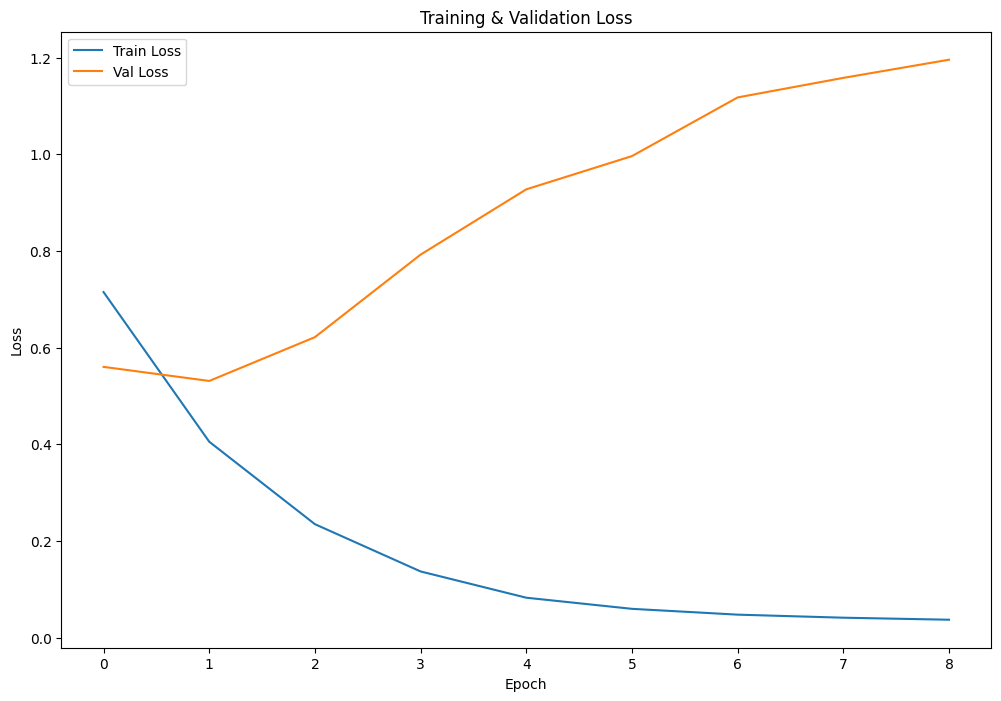

The learning curves are generated in pdf: training_validation_losses.pdf


'training_validation_losses.pdf'

In [37]:
# ---------------------------------------------------
# Plot training and validation loss
# ---------------------------------------------------
plot_losses_to_pdf(train_losses=train_losses_idf,
                   val_losses=val_losses_idf,
                   pdf_filename="training_validation_losses.pdf",
                   figsize=(12, 8),
                   show_plot=True)

## Αξιολόγηση στο Test Set

Μετά την εκπαίδευση και το early stopping, αξιολογούμε το μοντέλο στο **test set**.  
Χρησιμοποιούμε `eval()` για να απενεργοποιηθεί το dropout, και `torch.no_grad()` για πιο γρήγορο inference (χωρίς backpropagation).

In [38]:
model_idf.eval()               # eval mode: κλείνει dropout/batchnorm
correct = 0
total = 0

with torch.no_grad():      # χωρίς gradient για ταχύτερο inference
    for xb, yb in test_loader_idf:
        logits = model_idf(xb.float())          # [batch, num_classes] (ωμά logits)
        preds = torch.argmax(logits, dim=1) # προβλέψεις κλάσης
        correct += (preds == yb.long()).sum().item()
        total   += yb.size(0)

test_acc = 100.0 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 79.26%


**Συμπεράσματα:**
- Το μοντέλο με TF-IDF + ANN πέτυχε ~**79.3%** ακρίβεια στο test set.  
- Το αποτέλεσμα είναι κοντά στο validation accuracy της καλύτερης εποχής (Epoch 2 ≈ 79.2%),  
  γεγονός που δείχνει ότι το μοντέλο **γενικεύει σωστά** και δεν υπερεκπαιδεύτηκε.  

## Αναλυτική Αξιολόγηση (Classification Report)

Μετά την εξαγωγή των προβλέψεων με `get_preds`,  
χρησιμοποιούμε το `classification_report` της scikit-learn για λεπτομερή αξιολόγηση ανά κλάση.  

`Τι μας δίνει:`

**Precision:** πόσο ακριβείς είναι οι θετικές προβλέψεις.

**Recall:** πόσα από τα πραγματικά παραδείγματα μιας κλάσης βρήκε το μοντέλο.

**F1-score:** ισορροπία Precision/Recall.

**Support:** αριθμός πραγματικών δειγμάτων ανά κλάση.

Επίσης macro/weighted averages για σύνολο dataset.

Έτσι έχουμε πιο πλήρη εικόνα από το απλό accuracy.

In [39]:
y_true, y_pred = get_preds(model_idf, test_loader_idf)  # αν έχεις test_loader, βάλε το εκεί

# αναλυτικό report (per-class + macro/weighted)
print(classification_report(y_true, y_pred, digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.866     0.877     0.871       918
           1      0.604     0.577     0.590       307
           2      0.739     0.746     0.743       236

    accuracy                          0.793      1461
   macro avg      0.736     0.733     0.735      1461
weighted avg      0.790     0.793     0.791      1461



**Συμπεράσματα (TF-IDF με NUM):**
- Συνολικό **accuracy ≈ 79.3%**.
- **Κλάση 0 (Negative):** καλύτερη επίδοση, F1 ≈ 0.871 με αρκετά υψηλό recall (0.877).
- **Κλάση 1 (Neutral):** πιο δύσκολη, F1 ≈ 0.590 με recall 0.577 → πολλές ουδέτερες μπερδεύονται.
- **Κλάση 2 (Positive):** καλή ισορροπία precision/recall, F1 ≈ 0.743.

**Macro avg:** F1 ≈ 0.735  
**Weighted avg:** F1 ≈ 0.791 

Το μοντέλο μαθαίνει καλά τα **αρνητικά**, σχετικά καλά τα **θετικά**, αλλά χρειάζεται βελτίωση στα **ουδέτερα**.

## Φόρτωση Προεκπαιδευμένου Word2Vec

Για να δοκιμάσουμε την αναπαράσταση με Word2Vec, φορτώνουμε το προεκπαιδευμένο μοντέλο **Google News** (300 διαστάσεων).

Το μοντέλο αυτό περιέχει εκατομμύρια λέξεις/φράσεις και μπορεί να δώσει διανυσματικές αναπαραστάσεις για tokens.

Θα το χρησιμοποιήσουμε για να μετατρέψουμε κάθε tweet (λίστα tokens) σε μέσο όρο διανυσμάτων λέξεων.

In [40]:
w2v_path = r"C:\Users\giorg\PycharmProjects\PythonProject4\word2vec-google-news-300.model" 
w2v_model = KeyedVectors.load(w2v_path, mmap='r')
print("Vector size:", w2v_model.vector_size)

Vector size: 300


## Word2Vec Vectorization

Χρησιμοποιούμε τη `vectorize_texts` με `method="word2vec"` πάνω στη στήλη **`tokens`** (λίστα tokens).  
Το αποτέλεσμα είναι `X_w2v` όπου κάθε tweet είναι ο **μέσος όρος** των word embeddings.

## Word2Vec Pipeline

Ακολουθούμε παρόμοια βήματα με το TF-IDF pipeline:  
1. **Vectorization** των tweets με Word2Vec (tokens → embeddings).  
2. **Split** σε train/validation/test με `stratify`.  
3. **Μετατροπή** σε PyTorch tensors.  
4. **TensorDataset & DataLoader** με batch size = 32.  
5. **Ορισμός ANN μοντέλου** με input διαστάσεις = embedding size (300).  
6. **Loss, optimizer, scheduler, early stopping** όπως πριν.  
7. **Εκπαίδευση & αξιολόγηση** στο test set.  

Η μόνη διαφορά είναι ότι αντί για TF-IDF χαρακτηριστικά χρησιμοποιούμε τα **Word2Vec embeddings**.

In [41]:
# Word2Vec vectorization (tokens -> μέσος όρος embeddings)
X_w2v = vectorize_texts(
    df,
    feature_name="tokens",
    method="word2vec",
    model_path=w2v_path    # επιστρέφει (n_samples, emb_dim)
)
labels_w2v = df["label"].values

print("Shape (W2V):", X_w2v.shape)   # π.χ. (n, 300)

Loading Word2Vec model from: C:\Users\giorg\PycharmProjects\PythonProject4\word2vec-google-news-300.model
Vectorizing with Word2Vec...
Shape (W2V): (14606, 300)


In [42]:
# Train/Validation/Test split (W2V)
train_X_w2v, temp_X_w2v, train_y_w2v, temp_y_w2v = train_test_split(
    X_w2v, labels_w2v,
    test_size=0.20,
    random_state=42,
    stratify=labels_w2v
)

In [43]:
val_X_w2v, test_X_w2v, val_y_w2v, test_y_w2v = train_test_split(
    temp_X_w2v, temp_y_w2v,
    test_size=0.50,   # 10% val, 10% test
    random_state=42,
    stratify=temp_y_w2v
)


In [44]:
# Μετατροπή σε PyTorch tensors (W2V)
train_X_tensor_w2v = torch.tensor(train_X_w2v, dtype=torch.float32)
train_y_tensor_w2v = torch.tensor(train_y_w2v, dtype=torch.long)

val_X_tensor_w2v   = torch.tensor(val_X_w2v,   dtype=torch.float32)
val_y_tensor_w2v   = torch.tensor(val_y_w2v,   dtype=torch.long)

test_X_tensor_w2v  = torch.tensor(test_X_w2v,  dtype=torch.float32)
test_y_tensor_w2v  = torch.tensor(test_y_w2v,  dtype=torch.long)

In [45]:
# pca = PCA(n_components=0.90, svd_solver="full")   # ή "auto"
# train_X = pca.fit_transform(train_X)
# val_X   = pca.transform(val_X)
# test_X  = pca.transform(test_X)
# print(
#     f"PCA kept {pca.n_components_} comps "
#     f"(explained variance: {pca.explained_variance_ratio_.sum():.3f})"
# )

train_dataset_w2v = TensorDataset(train_X_tensor_w2v, train_y_tensor_w2v)
val_dataset_w2v   = TensorDataset(val_X_tensor_w2v,   val_y_tensor_w2v)
test_dataset_w2v  = TensorDataset(test_X_tensor_w2v,  test_y_tensor_w2v)

batch_size = 32
train_loader_w2v = DataLoader(train_dataset_w2v, batch_size=batch_size, shuffle=True)
val_loader_w2v   = DataLoader(val_dataset_w2v,   batch_size=batch_size, shuffle=False)
test_loader_w2v  = DataLoader(test_dataset_w2v,  batch_size=batch_size, shuffle=False)

print('The preprocessing of the W2V data is finished and the model is ready for training')

The preprocessing of the W2V data is finished and the model is ready for training


## Ορισμός Μοντέλου (ANN με W2V input)

Ορίζουμε τις διαστάσεις για το W2V pipeline:
- `input_dim_w2v` = διαστάσεις embedding (συνήθως 300)
- `output_dim_w2v` = αριθμός κλάσεων

Δημιουργούμε το μοντέλο `ANN` με δύο κρυφά επίπεδα και dropout:

```python
input_dim_w2v  = X_w2v.shape[1]      # π.χ. 300
output_dim_w2v = len(le.classes_)    # π.χ. 3

In [46]:
# Ορισμός μοντέλου (ANN με W2V input)
input_dim_w2v  = X_w2v.shape[1]      # π.χ. 300
output_dim_w2v = len(le.classes_)    # π.χ. 3

model_ann_w2v = ANN(
    input_dim=input_dim_w2v,
    output_dim=output_dim_w2v,
    hidden_layer1=256,
    hidden_layer2=256,
    dropoutp1=0.3,
    dropoutp2=0.3
)

In [47]:
# Class weights (προαιρετικό) για ανισορροπία κλάσεων
# classes_w2v = np.unique(train_y_w2v)  # π.χ. [0,1,2]
# cls_weights_w2v = compute_class_weight('balanced', classes=classes_w2v, y=train_y_w2v)
# cls_weights_w2v = torch.tensor(cls_weights_w2v, dtype=torch.float32)

# Loss function
# criterion_w2v = nn.CrossEntropyLoss(weight=cls_weights_w2v)  # ενεργοποίησε αν θέλεις weights
criterion_w2v = nn.CrossEntropyLoss()

# Optimizer
optimizer_w2v = torch.optim.Adam(model_ann_w2v.parameters(), lr=5e-4)

In [48]:
# Εκπαίδευση με early stopping (W2V)
num_epochs_w2v = 200

scheduler_w2v = torch.optim.lr_scheduler.LambdaLR(
    optimizer_w2v,
    lr_lambda=lambda e: max(0.0, 1.0 - e / float(num_epochs_w2v - 1))  # 1.0 → 0.0 linearly
)
# scheduler_w2v = ReduceLROnPlateau(optimizer_w2v, mode='min', factor=0.5, patience=2, min_lr=1e-6)

patience_w2v = 7

## Εκπαίδευση Μοντέλου (W2V)

Τρέχουμε τη συνάρτηση `train_model` με Word2Vec embeddings.  

- **Epochs:** 200  
- **Scheduler:** `LambdaLR` με γραμμική μείωση από 1.0 → 0.0  
- **Patience:** 7 (early stopping με αποθήκευση & restore των καλύτερων βαρών)  

In [49]:
model_w2v, train_losses_w2v, val_losses_w2v, train_accs_w2v, val_accs_w2v = train_model(
    model=model_ann_w2v,
    train_loader=train_loader_w2v,
    val_loader=val_loader_w2v,
    criterion=criterion_w2v,
    optimizer=optimizer_w2v,
    num_epochs=num_epochs_w2v,
    patience=patience_w2v,
    scheduler=scheduler_w2v
)

Epoch [1/200] | Train Loss: 0.6788 | Val Loss: 0.5685 | Train Acc: 0.7223 | Val Acc: 0.7728
Epoch [2/200] | Train Loss: 0.5550 | Val Loss: 0.5495 | Train Acc: 0.7834 | Val Acc: 0.7789
Epoch [3/200] | Train Loss: 0.5293 | Val Loss: 0.5374 | Train Acc: 0.7937 | Val Acc: 0.7823
Epoch [4/200] | Train Loss: 0.5115 | Val Loss: 0.5273 | Train Acc: 0.8015 | Val Acc: 0.7912
Epoch [5/200] | Train Loss: 0.4944 | Val Loss: 0.5338 | Train Acc: 0.8117 | Val Acc: 0.7782
Epoch [6/200] | Train Loss: 0.4843 | Val Loss: 0.5326 | Train Acc: 0.8133 | Val Acc: 0.7851
Epoch [7/200] | Train Loss: 0.4689 | Val Loss: 0.5358 | Train Acc: 0.8191 | Val Acc: 0.7817
Epoch [8/200] | Train Loss: 0.4521 | Val Loss: 0.5384 | Train Acc: 0.8284 | Val Acc: 0.7919
Epoch [9/200] | Train Loss: 0.4384 | Val Loss: 0.5326 | Train Acc: 0.8349 | Val Acc: 0.7844
Epoch [10/200] | Train Loss: 0.4243 | Val Loss: 0.5255 | Train Acc: 0.8386 | Val Acc: 0.7892
Epoch [11/200] | Train Loss: 0.4128 | Val Loss: 0.5356 | Train Acc: 0.8473 | Va


**Συμπεράσματα:**
- Καλύτερο **validation loss** στο **Epoch 7**: `0.5255` (Val Acc ≈ `0.789`).
- Μετά το Epoch 7 το train loss συνεχίζει να πέφτει, ενώ το val loss αρχίζει να ανεβαίνει ελαφρά → αρχή **overfitting**.
- Η **EarlyStopping** αποθήκευσε τα βάρη στο **Epoch 7** και έκανε **restore** στο τέλος.

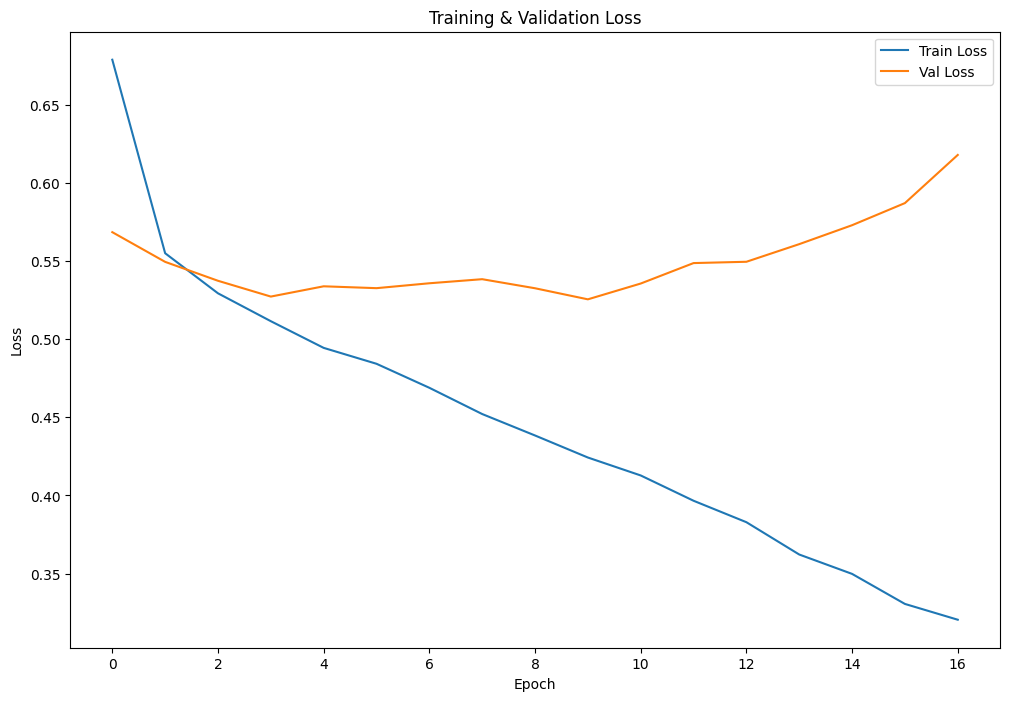

The learning curves are generated in pdf: training_validation_losses.pdf


'training_validation_losses.pdf'

In [50]:
# ---------------------------------------------------
# Plot training and validation loss
# ---------------------------------------------------
plot_losses_to_pdf(train_losses=train_losses_w2v,
                   val_losses=val_losses_w2v,
                   pdf_filename="training_validation_losses.pdf",
                   figsize=(12, 8),
                   show_plot=True)

In [51]:
# Test accuracy (W2V)
model_w2v.eval()
correct_w2v, total_w2v = 0, 0

with torch.no_grad():
    for xb, yb in test_loader_w2v:
        preds = model_w2v(xb.float()).argmax(1)
        correct_w2v += (preds == yb).sum().item()
        total_w2v   += yb.size(0)

test_acc_w2v = 100.0 * correct_w2v / total_w2v
print(f"Test Accuracy (W2V): {test_acc_w2v:.2f}%")

Test Accuracy (W2V): 79.74%


**Παρατηρήσεις:**
- Η επίδοση `(~79.8%)` είναι πολύ κοντά με αυτή του TF-IDF μοντέλου `(~79.3%)`.  
- Αυτό δείχνει ότι και οι δύο προσεγγίσεις (TF-IDF και Word2Vec embeddings) δίνουν **παρόμοια ικανότητα γενίκευσης**.  

In [52]:
# Classification report (W2V)
y_true_w2v, y_pred_w2v = get_preds(model_w2v, test_loader_w2v)

from sklearn.metrics import classification_report
print(classification_report(y_true_w2v, y_pred_w2v, digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.846     0.912     0.878       918
           1      0.651     0.498     0.565       307
           2      0.738     0.742     0.740       236

    accuracy                          0.797      1461
   macro avg      0.745     0.717     0.727      1461
weighted avg      0.788     0.797     0.790      1461



**Συμπεράσματα (W2V με NUM):**
- Συνολικό **accuracy ≈ 79.7%**, ελαφρώς καλύτερο από το TF-IDF (~79.3%).  
- **Κλάση 0 (Negative):** κορυφαία επίδοση, F1 ≈ 0.878 με recall 0.912.  
- **Κλάση 1 (Neutral):** δυσκολότερη, F1 ≈ 0.565 με recall 0.498 → χαμηλή κάλυψη των ουδέτερων tweets.  
- **Κλάση 2 (Positive):** καλή ισορροπία, F1 ≈ 0.740.  

**Macro avg:** F1 ≈ 0.727  
**Weighted avg:** F1 ≈ 0.790  

Το W2V δίνει ελαφρώς καλύτερη συνολική απόδοση, κυρίως χάρη στη βελτίωση στα **αρνητικά** και **θετικά**, αλλά το πρόβλημα στα **ουδέτερα** παραμένει. 

## Confusion Matrices: TF-IDF vs W2V

Παράγουμε **confusion matrices** για το test set και τα πλοτάρουμε δίπλα-δίπλα, ώστε να συγκρίνουμε γρήγορα τα λάθη των δύο μοντέλων.

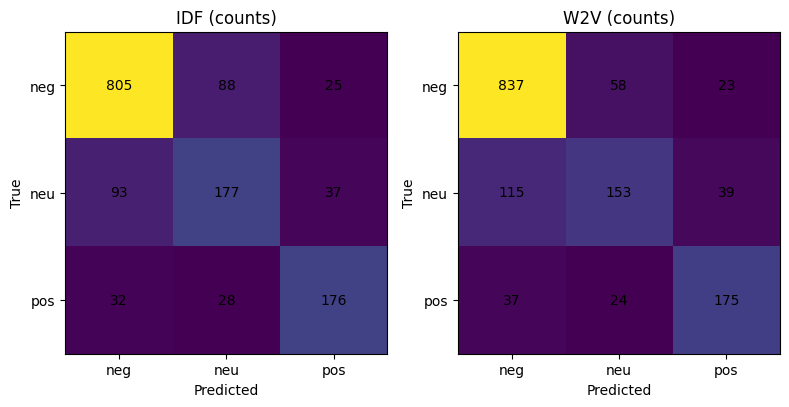

In [59]:
y_true_idf, y_pred_idf = get_preds(model_idf, test_loader_idf)
y_true,      y_pred    = get_preds(model_w2v, test_loader_w2v)

labels = [0, 1, 2]
class_names = ["neg", "neu", "pos"]

# 2) Φτιάξε τα confusion matrices (counts)
cm_idf = confusion_matrix(y_true_idf, y_pred_idf, labels=labels)
cm_w2v = confusion_matrix(y_true,     y_pred,     labels=labels)

# 3) Πλοτάρισμα δίπλα-δίπλα (counts)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for ax, cm, title in zip(axes, [cm_idf, cm_w2v], ["IDF (counts)", "W2V (counts)"]):
    im = ax.imshow(cm)
    ax.set_xticks(labels); ax.set_yticks(labels)
    ax.set_xticklabels(class_names); ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.tight_layout(); plt.show()

## Ανάγνωση πίνακα:

`Κύρια διαγώνιος` = σωστές προβλέψεις.

`Εκτός διαγώνιου`= λάθη (π.χ. πόσα neu ταξινομήθηκαν ως neg/pos).

`Συγκρίνουμε TF-IDF vs W2V`: ποιο έχει περισσότερα σωστά στην κύρια διαγώνιο, ειδικά για neu, όπου είδαμε χαμηλότερο recall.

## Normalized Confusion Matrices (TF-IDF vs W2V)

Για καλύτερη κατανόηση της απόδοσης σε κάθε κλάση, κανονικοποιούμε τα confusion matrices ώστε κάθε γραμμή να αθροίζει σε **1.0 (100%)**. Έτσι φαίνεται καθαρά το **ποσοστό** των σωστών/λανθασμένων ταξινομήσεων ανά κλάση.

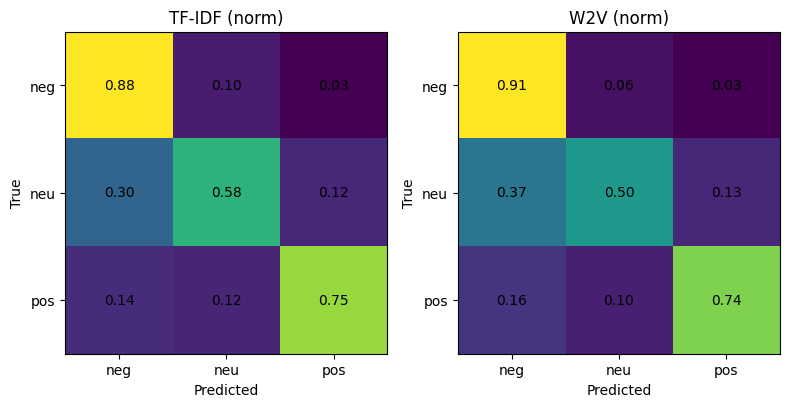

In [60]:
# Normalized confusion matrices (row-wise)
cm_idf_norm = cm_idf.astype(float) / cm_idf.sum(axis=1, keepdims=True)
cm_w2v_norm = cm_w2v.astype(float) / cm_w2v.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for ax, cm, title in zip(axes, [cm_idf_norm, cm_w2v_norm], ["TF-IDF (norm)", "W2V (norm)"]):
    im = ax.imshow(cm)
    ax.set_xticks(labels); ax.set_yticks(labels)
    ax.set_xticklabels(class_names); ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]:.2f}", ha="center", va="center")
plt.tight_layout(); plt.show()

## Confusion Matrices με Βάρη (Weighted CrossEntropy)

Η παρακάτω εικόνα δείχνει τα **normalized confusion matrices** για **TF-IDF** και **W2V** όταν το training έγινε με **weighted loss**.  
- Με τα βάρη, αυξάνεται το **recall** σε **neutral** (~0.60) και **positive** (TF-IDF ~0.79, W2V ~0.83),  
  ενώ μειώνεται το **recall** στα **negative** (TF-IDF ~0.83, W2V ~0.79) — σύμφωνο με τα reports.  
- Οι διαγώνιοι αριθμοί είναι το **per-class recall** (ποσοστό σωστών ανά κλάση).

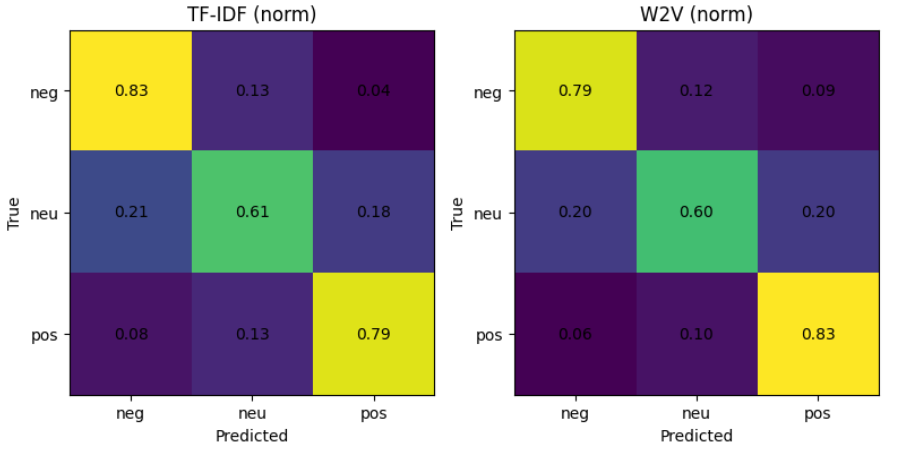